# 🛡 ML-антифрод система: Baseline-модель

**Цель:** построить baseline-модель, которая по агрегированным пользовательским фичам предсказывает вероятность того, что пользователь является фродовым (`is_fraud_user`).

Под фродовым пользователем считаем того, у кого за период были:
- chargeback (`CHARGEBACK`)  
- alert (`ALERT_FEE`)  
- либо refund (`CREDIT`).

Модель работает **на уровне пользователя (user_email)**, а не транзакций.

В ноутбуке:

1. Загрузка данных и очистка
2. Разведочный анализ данных (EDA)  
3. Моделирование:
   - Logistic Regression (baseline)
   - Random Forest (baseline деревья)
   - CatBoost (усложнённая модель с учётом категориальных фичей)
4. Оценка качества (ROC-AUC, PR-AUC, precision/recall/F1, Precision@K) и аналитический вывод.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import clickhouse_connect
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    average_precision_score,
    precision_recall_curve,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

### 1. Загрузка и очистка данных

В этом разделе мы загружаем данные из хранилища (DWH ClickHouse), используя ранее подготовленный SQL-запрос.
Мы агрегируем признаки по пользователям в двух витринах:

- dim_merchant_transactions — платёжная активность юзера
- dim_client_paysites_member_transactions — регистрационная активность, устройства, каналы, cross-поведение

Перед объединением данные были очищены:
- нормализованы email (lower + trim)
- исключены тестовые транзакции
- удалены строки с пустыми email
- отфильтрованы нужные типы событий (SALE, rebill, trial, initial, conversion)
- нормализованы даты
- агрегированы на уровне пользователя (чтобы модель работала по user_email, а не по транзакциям)

Ниже — финальный SQL-запрос, который формирует ML-таблицу:

In [2]:
# Загрузка переменных среды
load_dotenv()
user = 'user'
click_password = 'click_password'

# Подключение к ClickHouse
client = clickhouse_connect.get_client(
    host='host',
    port=port,
    username=user,
    password=click_password,
    compression=True,
    connect_timeout=600, 
    send_receive_timeout=600
)

In [3]:
def fetch_data_from_db(query, client):
    '''Запрос к DWH. Необходимо передать строку запроса и клиента подключения'''
    result = client.query(query)
    data = result.result_rows
    columns = result.column_names
    return pd.DataFrame(data, columns=columns)

In [4]:
query = """
WITH
dm_features AS (
    SELECT
        lower(trim(user_email)) AS user_email,
        (   countIf(transaction_type = 'CHARGEBACK') > 0
            OR countIf(transaction_type = 'ALERT_FEE') > 0
            OR countIf(transaction_type = 'CREDIT') > 0) AS is_fraud_user,
        
        countIf(transaction_type = 'SALE') AS n_sales,
        countIf(transaction_type = 'SALE' AND transaction_status = 'DECLINED') AS n_declines,
        if(n_sales > 0, n_declines / n_sales, 0) AS decline_ratio,
        avgIf(amount, transaction_type = 'SALE') AS avg_sale_amount,
        maxIf(amount, transaction_type = 'SALE') AS max_sale_amount,
        minIf(amount, transaction_type = 'SALE') AS min_sale_amount,
        uniqIf(event_date, transaction_type = 'SALE') AS n_active_days,
        if(n_sales > 0, n_active_days / n_sales, 0) AS sales_density,
        minIf(event_date, transaction_type = 'SALE') AS min_sale_date,
        uniq(source_country) AS unique_countries,
        uniq(card_brand) AS unique_card_brands,
        uniq(gateway) AS unique_gateways,
        uniq(mid) AS unique_mids,
        uniq(site_name) AS unique_sites,
        uniq(project) AS unique_projects,
        countIf(transaction_sub_type = 'trial') AS n_trials,
        countIf(transaction_sub_type = 'rebill') AS n_rebills,
        countIf(transaction_sub_type = 'upgrade') AS n_upgrades,
        countIf(transaction_sub_type = 'conversion') AS n_conversions,
        countIf(transaction_sub_type = 'onetime') AS n_onetime,
        uniq(site_name) > 3 AS multi_site_flag,
        uniq(project) > 2 AS multi_project_flag,
        countIf(bin_country != source_country) > 0 AS geo_mismatch_any,
        anyHeavy(attraction_affiliate_username) AS main_affiliate,
        uniq(attraction_affiliate_username) AS unique_affiliates
    FROM dbt_mart.dim_merchant_transactions
    WHERE event_date >= toDate('2023-01-01')
      AND transaction_type IN ('SALE', 'CHARGEBACK', 'ALERT_FEE', 'CREDIT')
      AND is_test = 0
      AND project != 'adxad'
      AND user_email IS NOT NULL
      AND user_email != ''
    GROUP BY user_email
),
dc_features AS (
    SELECT
        lower(trim(member_email)) AS user_email,
        uniq(member_id) AS n_members,
        count(*) AS n_dc_events,
        min(attraction_date) AS first_reg_date,
        max(attraction_date) AS last_reg_date,
        uniq(attraction_date) AS n_reg_dates,
        uniq(member_id) / uniq(attraction_date) AS members_per_regdate, 
        anyHeavy(device_type) AS device_type,
        anyHeavy(os) AS os,
        anyHeavy(channel) AS channel,
        avg(is_cross) AS cross_ratio
    FROM dbt_mart.dim_client_paysites_member_transactions
    WHERE event_date >= toDate('2023-01-01')
      AND trans_type IN ('initial','onetime','rebill','trial','conversion')
      AND member_email IS NOT NULL
      AND member_email != ''
      AND trim(member_email) != ''
    GROUP BY user_email
)

SELECT
    coalesce(dm.user_email, dc.user_email) AS user_email,
    dm.* EXCEPT user_email,
    dc.* EXCEPT user_email
FROM dm_features dm
LEFT JOIN dc_features dc
    ON dm.user_email = dc.user_email

"""

In [5]:
df = fetch_data_from_db(query, client)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289303 entries, 0 to 289302
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype                  
---  ------               --------------   -----                  
 0   user_email           289303 non-null  object                 
 1   is_fraud_user        289303 non-null  int64                  
 2   n_sales              289303 non-null  int64                  
 3   n_declines           289303 non-null  int64                  
 4   decline_ratio        289303 non-null  float64                
 5   avg_sale_amount      289126 non-null  float64                
 6   max_sale_amount      289303 non-null  float64                
 7   min_sale_amount      289303 non-null  float64                
 8   n_active_days        289303 non-null  int64                  
 9   sales_density        289303 non-null  float64                
 10  min_sale_date        289303 non-null  datetime64[ns, Etc/UTC]
 11  unique_countr

In [7]:
#Преобразуем даты к datetime
date_cols = ['first_reg_date', 'last_reg_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
#Смотрим пропуски
df.isna().mean().sort_values(ascending=False)

avg_sale_amount        0.000612
user_email             0.000000
n_dc_events            0.000000
n_onetime              0.000000
multi_site_flag        0.000000
multi_project_flag     0.000000
geo_mismatch_any       0.000000
main_affiliate         0.000000
unique_affiliates      0.000000
n_members              0.000000
first_reg_date         0.000000
n_upgrades             0.000000
last_reg_date          0.000000
n_reg_dates            0.000000
members_per_regdate    0.000000
device_type            0.000000
os                     0.000000
channel                0.000000
n_conversions          0.000000
n_rebills              0.000000
is_fraud_user          0.000000
sales_density          0.000000
n_sales                0.000000
n_declines             0.000000
decline_ratio          0.000000
max_sale_amount        0.000000
min_sale_amount        0.000000
n_active_days          0.000000
min_sale_date          0.000000
n_trials               0.000000
unique_countries       0.000000
unique_c

In [8]:
# Заполнение пропусков в среднем чеке
df["avg_sale_amount"] = df["avg_sale_amount"].fillna(0)

### 2. Анализ данных (EDA)

В этом разделе мы исследуем:
- распределение целевой переменной (fraud vs non-fraud)
- корреляции числовых признаков
- основные статистики
- выбросы и аномальные значения

In [9]:
# 2.1. Баланс классов
df['is_fraud_user'].value_counts(normalize=True)

is_fraud_user
0    0.93635
1    0.06365
Name: proportion, dtype: float64

Ожидаемый вывод:
- Класс 0 ≈ 94%
- Класс 1 ≈ 6%
Это сильный imbalance → важно учитывать при обучении (CatBoost умеет, LogReg/RandomForest — нет).

In [10]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
is_fraud_user,289303.0,0.063650,0.244128,0.0,0.000000,0.000,0.000000,1.0
n_sales,289303.0,7.718285,54.062330,0.0,2.000000,4.000,9.000000,28461.0
n_declines,289303.0,5.530154,53.487417,0.0,1.000000,2.000,7.000000,28371.0
decline_ratio,289303.0,0.723923,0.347637,0.0,0.500000,0.875,1.000000,1.0
avg_sale_amount,289303.0,19.285965,33.702284,0.0,0.475000,1.842,29.526667,999.0
max_sale_amount,289303.0,36.808037,51.025781,0.0,1.000000,6.500,59.990002,999.0
min_sale_amount,289303.0,7.148584,29.558293,0.0,0.000000,1.000,1.000000,999.0
n_active_days,289303.0,4.132470,6.811335,0.0,1.000000,1.000,5.000000,265.0
sales_density,289303.0,0.595641,0.302974,0.0,0.333333,0.500,1.000000,1.0
unique_countries,289303.0,1.096805,0.359641,1.0,1.000000,1.000,1.000000,20.0


Text(0.5, 1.0, 'Boxplot основных числовых признаков')

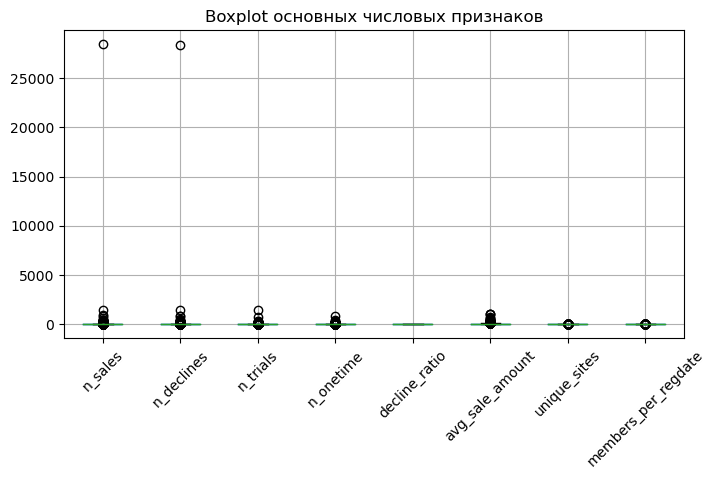

In [11]:
cols = ["n_sales", "n_declines", "n_trials", "n_onetime", "decline_ratio", "avg_sale_amount", "unique_sites", "members_per_regdate"]
plt.figure(figsize=(8,4))
df[cols].boxplot(rot=45)
plt.title("Boxplot основных числовых признаков")

In [12]:
#обрабатываем выбросы
count_like_cols = [
    "n_sales", "n_declines",
    "n_trials", "n_rebills", "n_upgrades", "n_conversions", "n_onetime",
    "n_members", "n_dc_events",
    "n_reg_dates"
]

amount_cols = ["avg_sale_amount", "max_sale_amount", "min_sale_amount"]

# Временной размах по датам регистрации
if "diff_reg_date" in df.columns:
    # Ограничим, например, 95 перцентилем или максимумом в разумном диапазоне
    q95 = df["diff_reg_date"].quantile(0.95)
    df["diff_reg_date"] = df["diff_reg_date"].clip(lower=0, upper=q95)


def cap_by_quantile(df, cols, q=0.99):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            upper = df[c].quantile(q)
            df[c] = df[c].clip(upper=upper)
    return df


df = cap_by_quantile(df, count_like_cols, q=0.99)
df = cap_by_quantile(df, amount_cols, q=0.99)

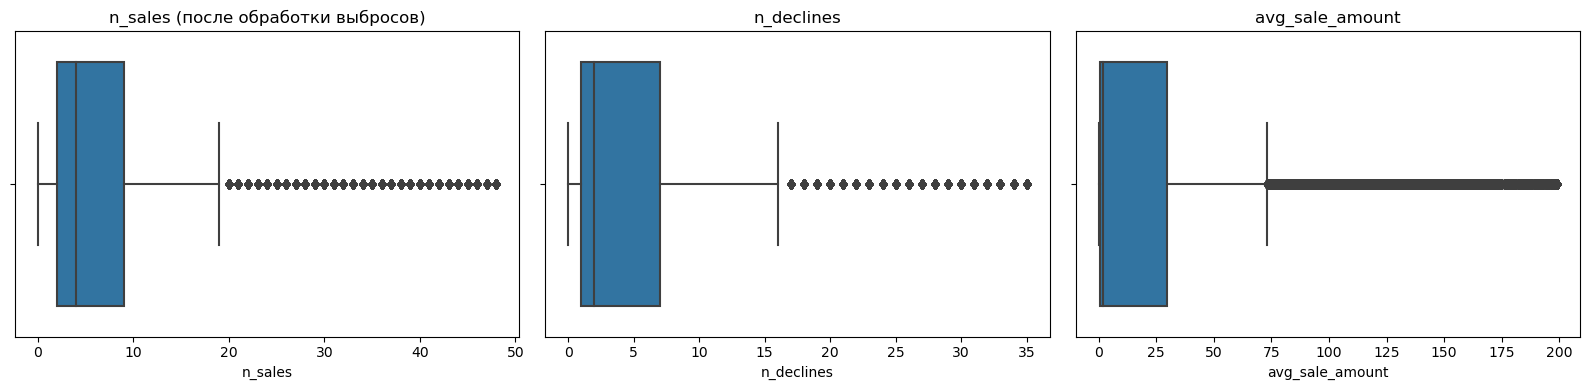

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(x=df["n_sales"], ax=axes[0])
axes[0].set_title("n_sales (после обработки выбросов)")
sns.boxplot(x=df["n_declines"], ax=axes[1])
axes[1].set_title("n_declines")
sns.boxplot(x=df["avg_sale_amount"], ax=axes[2])
axes[2].set_title("avg_sale_amount")
plt.tight_layout()

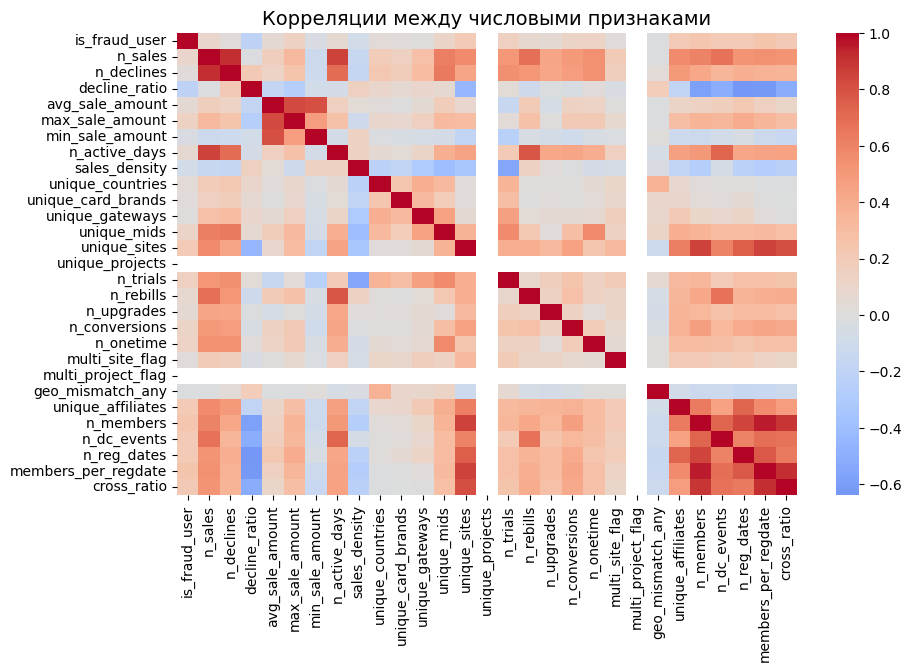

In [14]:
#2.2. Корреляции числовых признаков
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.show()

In [15]:
#ТОП корреляций 
df.corr(numeric_only=True)['is_fraud_user'].sort_values(ascending=False).head(15)

is_fraud_user          1.000000
members_per_regdate    0.248640
n_members              0.244343
cross_ratio            0.216275
unique_sites           0.211421
n_dc_events            0.209847
n_reg_dates            0.209577
unique_affiliates      0.208716
n_trials               0.152534
max_sale_amount        0.142566
n_onetime              0.125488
n_conversions          0.119749
unique_mids            0.113034
n_sales                0.101818
n_rebills              0.072668
Name: is_fraud_user, dtype: float64

#### **Наблюдения по EDA:**

- Доля фрод-юзеров ~6–7% ⇒ сильный дисбаланс классов.
- `n_trials`, `n_sales`, `decline_ratio`, `n_members`, `members_per_regdate`, `cross_ratio` положительно коррелируют с `is_fraud_user`.
- У фродовых пользователей чаще:
  - больше транзакций и попыток (n_sales, n_declines),
  - выше доля неуспешных попыток (decline_ratio),
  - больше разных аффилейтов (unique_affiliates) и сайтов (unique_sites),
  - более плотная активность.


### 3. Базовые модели + усложнённая модель
После подготовки данных мы обучаем три типа моделей:

In [16]:
# Целевая переменная и фичи
target = "is_fraud_user"
drop_cols = ["user_email", "min_sale_date", "first_reg_date", "last_reg_date"]  

X = df.drop(columns=[target] + drop_cols)
y = df[target]

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical features:", cat_features)
print("Numeric features:", num_features)

Categorical features: ['main_affiliate', 'device_type', 'os', 'channel']
Numeric features: ['n_sales', 'n_declines', 'decline_ratio', 'avg_sale_amount', 'max_sale_amount', 'min_sale_amount', 'n_active_days', 'sales_density', 'unique_countries', 'unique_card_brands', 'unique_gateways', 'unique_mids', 'unique_sites', 'unique_projects', 'n_trials', 'n_rebills', 'n_upgrades', 'n_conversions', 'n_onetime', 'multi_site_flag', 'multi_project_flag', 'geo_mismatch_any', 'unique_affiliates', 'n_members', 'n_dc_events', 'n_reg_dates', 'members_per_regdate', 'cross_ratio']


In [17]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,           
    random_state=42
)

print("Train fraud ratio:", y_train.mean())
print("Test fraud ratio:", y_test.mean())

print("Train fraud count:", y_train.sum())
print("Test fraud count:", y_test.sum())

print("Total fraud count:", y.sum())

Train fraud ratio: 0.06364877593522351
Test fraud ratio: 0.06365254662034876
Train fraud count: 14731
Test fraud count: 3683
Total fraud count: 18414


In [18]:
# Препроцессор (OneHot для категорий + scaler для числовых)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

#### 3.1. Простая модель 1 — Logistic Regression

In [19]:
logreg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC:", average_precision_score(y_test, y_proba_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.987     0.829     0.902     54178
           1      0.251     0.843     0.387      3683

    accuracy                          0.830     57861
   macro avg      0.619     0.836     0.644     57861
weighted avg      0.940     0.830     0.869     57861

ROC-AUC: 0.9130381078001881
PR-AUC: 0.49321856128791486


#### 3.2. Простая модель 2 — Random Forest

In [20]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0      0.984     0.937     0.960     54178
           1      0.453     0.774     0.572      3683

    accuracy                          0.926     57861
   macro avg      0.719     0.855     0.766     57861
weighted avg      0.950     0.926     0.935     57861

ROC-AUC: 0.9573659294865438
PR-AUC: 0.7210300891780029


#### 3.3. Усложнённая модель — CatBoost (tuned)

In [21]:
cat_tuned = CatBoostClassifier(
    iterations=1500,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=5,
    random_strength=1,
    border_count=254,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, 12], 
    verbose=100,
    random_seed=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_tuned.fit(train_pool, eval_set=test_pool)

y_pred_cat = (cat_tuned.predict_proba(test_pool)[:, 1] > 0.5).astype(int)
y_proba_cat = cat_tuned.predict_proba(test_pool)[:, 1]

print("=== CatBoost Tuned (threshold=0.5) ===")
print(classification_report(y_test, y_pred_cat, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cat))
print("PR-AUC:", average_precision_score(y_test, y_proba_cat))

0:	test: 0.8981486	best: 0.8981486 (0)	total: 208ms	remaining: 5m 11s
100:	test: 0.9597502	best: 0.9597502 (100)	total: 9.94s	remaining: 2m 17s
200:	test: 0.9669683	best: 0.9669683 (200)	total: 19.4s	remaining: 2m 5s
300:	test: 0.9715657	best: 0.9715657 (300)	total: 28.8s	remaining: 1m 54s
400:	test: 0.9742374	best: 0.9742374 (400)	total: 38.5s	remaining: 1m 45s
500:	test: 0.9760937	best: 0.9760937 (500)	total: 48.4s	remaining: 1m 36s
600:	test: 0.9771496	best: 0.9771496 (600)	total: 59.2s	remaining: 1m 28s
700:	test: 0.9776734	best: 0.9776734 (700)	total: 1m 10s	remaining: 1m 19s
800:	test: 0.9781517	best: 0.9781663 (795)	total: 1m 21s	remaining: 1m 11s
900:	test: 0.9784719	best: 0.9784741 (897)	total: 1m 31s	remaining: 1m 1s
1000:	test: 0.9787546	best: 0.9787638 (986)	total: 1m 42s	remaining: 50.9s
1100:	test: 0.9789404	best: 0.9789443 (1098)	total: 1m 52s	remaining: 40.7s
1200:	test: 0.9791358	best: 0.9791358 (1200)	total: 2m 2s	remaining: 30.4s
1300:	test: 0.9792280	best: 0.9792332

In [24]:
# Важность признаков
feature_importances = pd.DataFrame({
    "feature": cat_tuned.feature_names_,
    "importance": cat_tuned.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importances.head(10)

,feature,importance
14,n_trials,13.967726
2,decline_ratio,10.035383
0,n_sales,7.476305
4,max_sale_amount,6.595635
3,avg_sale_amount,5.801112
15,n_rebills,5.726323
23,unique_affiliates,5.661324
16,n_upgrades,4.442167
17,n_conversions,4.212272
7,sales_density,3.849824


In [29]:
# Precision@K для CatBoost
def precision_at_k(y_true, y_proba, ks=[50, 100, 200, 500, 1000, 2000]):
    """
    Рассчитывает Precision@K для множества K.
    y_true  — реальные метки (0/1)
    y_proba — вероятности класса 1 (fraud)
    """

    # сортируем по убыванию вероятности фрода
    df = pd.DataFrame({"y_true": y_true, "proba": y_proba_cat})
    df_sorted = df.sort_values("proba", ascending=False).reset_index(drop=True)

    results = {}

    for k in ks:
        if k > len(df_sorted):
            results[f"P@{k}"] = None
            continue

        top_k = df_sorted.head(k)
        precision = top_k["y_true"].mean()   # доля фродеров среди TOP-K
        results[f"P@{k}"] = precision
    
    return pd.Series(results)


ks = [50, 100, 200, 500, 1000, 2000, 5000]

precision_k = precision_at_k(y_test, y_proba_cat, ks)
print(precision_k)

P@50      1.0000
P@100     1.0000
P@200     1.0000
P@500     1.0000
P@1000    1.0000
P@2000    0.9940
P@5000    0.6294
dtype: float64


### Подбор гиперпараметров с помощью AutoML

In [31]:
from flaml.automl.automl import AutoML

automl = AutoML()

settings = {
    "time_budget": 300, 
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": "automl_fraud.log",
}

automl.fit(X_train, y_train, **settings)

print("Best model:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best ROC-AUC:", 1 - automl.best_loss)

[flaml.automl.logger: 12-01 21:32:16] {1752} INFO - task = classification
[flaml.automl.logger: 12-01 21:32:16] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-01 21:32:16] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 12-01 21:32:16] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 12-01 21:32:16] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-01 21:32:16] {2417} INFO - Estimated sufficient time budget=13056s. Estimated necessary time budget=322s.
[flaml.automl.logger: 12-01 21:32:16] {2466} INFO -  at 1.2s,	estimator lgbm's best error=0.1657,	best estimator lgbm's best error=0.1657
[flaml.automl.logger: 12-01 21:32:16] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-01 21:32:16] {2466} INFO -  at 1.3s,	estimator lgbm's best error=0.1548,	best estimator lgbm's best error=0.1548
[flaml.au

In [32]:
y_pred_proba = automl.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC:", average_precision_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     54178
           1       0.93      0.72      0.81      3683

    accuracy                           0.98     57861
   macro avg       0.96      0.86      0.90     57861
weighted avg       0.98      0.98      0.98     57861

ROC-AUC: 0.9812352183854856
PR-AUC: 0.8881599757643627


In [35]:
from sklearn.metrics import recall_score

def evaluate_model(name, y_true, y_pred, y_proba):
    """Сохраняем ключевые метрики для сравнения моделей"""
    return {
        "model": name,
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "recall_fraud": recall_score(y_true, y_pred),
        "f1_fraud": f1_score(y_true, y_pred),
    }

results = []
# Logistic Regression
results.append(evaluate_model("LogReg", y_test, y_pred_lr, y_proba_lr))
# Random Forest
results.append(evaluate_model("RandomForest", y_test, y_pred_rf, y_proba_rf))
# CatBoost Tuned
results.append(evaluate_model("CatBoost Tuned", y_test, y_pred_cat, y_proba_cat))
results_df = pd.DataFrame(results)
# AutoML(LGBM)
results.append(evaluate_model("AutoML(LGBM / XGB LimitDepth)", y_test, y_pred, y_pred_proba))
results_df = pd.DataFrame(results)
results_df

,model,roc_auc,pr_auc,recall_fraud,f1_fraud
0,LogReg,0.913038,0.493219,0.842791,0.387371
1,RandomForest,0.957366,0.721030,0.774097,0.571686
2,CatBoost Tuned,0.979328,0.877985,0.860711,0.715656
3,AutoML(LGBM / XGB LimitDepth),0.981235,0.888160,0.717622,0.811982


## Выводы по моделям

**Logistic Regression**

- Хороша как baseline.
- Простая и интерпретируемая.
- Недостаточно ловит сложные паттерны → низкий F1.

**Random Forest**

- Существенно лучше логрегрессии.
- Хороший recall и F1.
- Но уступает CatBoost.

⭐ **CatBoost (tuned) — лучший результат**

- Лучшая метрика ROC-AUC ≈ 0.979
- PR-AUC ≈ 0.878
- Высокий recall по фроду при хорошем precision
- В топ-N списке практически все фродовые пользователи → идеально для антифрода

**AutoML LGBM / XGB LimitDepth**
(модель, автоматически подобранная FLAML)

- Лучший ROC-AUC среди всех: ≈ 0.9812
- PR-AUC также самая высокая: 0.888
- Однако recall по фроду ниже (0.71), чем у CatBoost.
- Дает более «осторожную» модель, которая меньше ловит сложные паттерны фрода.

#### 📌 Итог

- **CatBoost (tuned)** оптимальная модель для антифрода, если цель — минимизировать пропущенный фрод (высокий recall при хорошем precision).
- **AutoML (LGBM/XGB) ** — отличная альтернатива для максимально высокого ROC-AUC и PR-AUC, но с более низким recall.